In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGBC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from scipy.stats import loguniform, randint
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
import joblib

In [2]:
# Defining a function that runs a randomized search CV 
def run_search(X_train, y_train, pipeline, param_grid, name, n_iter = 50):
    '''
    Runs RandomizedSearchCV with stratified CV, returns the fitted search object and best estimator.
    '''
    search = RandomizedSearchCV(
        pipeline,
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23),
        scoring = 'average_precision', # average precision used as the scoring metric
        refit = True,
        n_jobs = -1,
        verbose = 1,
        random_state = 23
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    print(f'[{name}] Best Parameters: {best_params}')
    print(f'[{name}] Best CV average precision: {best_score:.3f}\n')

    return search, best_model

# Defining a function that runs Stratified K-Fold CV on training data 
def get_threshold_summary(model, X_tr, y_tr, n_splits = 5):
    '''
    Performs Stratified K-Fold CV, computes optimal probability threshold per fold using F1, 
    and returns summary statistics including chosen threshold and average F1 across folds.
    '''
    cv = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 23)
    fold_thresholds = []
    fold_f1s = []

    for train_idx, val_idx in cv.split(X_tr, y_tr):
        X_train_fold = X_tr.iloc[train_idx]
        y_train_fold = y_tr.iloc[train_idx]
        X_val_fold = X_tr.iloc[val_idx]
        y_val_fold = y_tr.iloc[val_idx]
        
        fold_model = clone(model)
        fold_model.fit(X_train_fold, y_train_fold)
        probs_val = fold_model.predict_proba(X_val_fold)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_val_fold, probs_val)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
        f1_scores = f1_scores[:-1]  

        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        fold_thresholds.append(best_thresh)
        fold_f1s.append(best_f1)

    thresholds_arr = np.array(fold_thresholds)
    mean_thresh = np.mean(thresholds_arr)
    median_thresh = np.median(thresholds_arr)
    std_thresh = np.std(thresholds_arr)
    q1, q3 = np.percentile(thresholds_arr, [25, 75])
    iqr = q3 - q1

    # Stability rule: pick median if variability is high
    if std_thresh > 0.1 or iqr > 0.1:
        chosen_threshold = median_thresh
        reason = 'high variability → median'
    else:
        chosen_threshold = mean_thresh
        reason = 'stable thresholds → mean'

    summary = {
        'fold_thresholds': fold_thresholds,
        'mean_thresh': mean_thresh,
        'median_thresh': median_thresh,
        'std_thresh': std_thresh,
        'iqr': iqr,
        'chosen_threshold': chosen_threshold,
        'reason': reason,
        'mean_f1_cv': np.mean(fold_f1s)
    }
    return summary

# Printing the summaries of the training data
def print_threshold_summary(name, summary):
    '''
    Nicely formats and prints out threshold summary statistics from get_threshold_summary.
    '''
    print(f'\n=== Threshold summary for {name} ===')
    print(f"Mean threshold: {summary['mean_thresh']:.3f}")
    print(f"Median threshold: {summary['median_thresh']:.3f}")
    print(f"Std: {summary['std_thresh']:.3f}, IQR: {summary['iqr']:.3f}")
    print(f"Chosen threshold: {summary['chosen_threshold']:.3f} ({summary['reason']})")
    print(f"Mean F1 across folds (best per-fold): {summary['mean_f1_cv']:.3f}")

In [3]:
# Loading in the dataset as a dataframe
df = pd.read_csv('/Users/jackewings/Documents/Projects/All-NBA-Prediction/data/processed/player_stats_all_nba.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head()

,player_id,player,season,age,pts_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,x2p_percent,x3p_percent,ft_percent,x3p_ar,f_tr,usg_percent,orb_percent,drb_percent,ows,dws,obpm,dbpm,all_nba
0,acyqu01,Quincy Acy,2015,24.0,5.9,4.4,1.0,0.40,0.3,0.494,0.300,0.784,0.181,0.293,15.50,6.9,20.50,1.0,0.7,-2.10,-1.00,0
1,adamsst01,Steven Adams,2015,21.0,7.7,7.5,0.9,0.50,1.2,0.547,0.000,0.502,0.005,0.514,14.30,12.2,19.30,1.9,2.2,-1.50,0.20,0
2,afflaar01,Arron Afflalo,2015,29.0,13.9,3.3,1.8,0.55,0.1,0.474,0.346,0.842,0.374,0.227,19.45,1.2,9.95,1.5,0.7,-1.05,-1.15,0
3,ajincal01,Alexis Ajinça,2015,26.0,6.5,4.6,0.7,0.30,0.8,0.550,0.000,0.818,0.000,0.301,21.10,12.4,25.00,1.9,1.2,-0.70,0.40,0
4,aldrico01,Cole Aldrich,2015,26.0,5.5,5.5,1.2,0.60,1.1,0.478,0.000,0.781,0.000,0.213,18.30,11.6,28.90,0.8,1.4,-0.80,1.10,0


In [4]:
# Checking for duplicates, NANs, and observing the data types and structure of the dataframe
print(f'There are {df.duplicated().sum()} duplicated rows\n')
df.info()

There are 0 duplicated rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     3198 non-null   object 
 1   player        3198 non-null   object 
 2   season        3198 non-null   int64  
 3   age           3198 non-null   float64
 4   pts_per_game  3198 non-null   float64
 5   trb_per_game  3198 non-null   float64
 6   ast_per_game  3198 non-null   float64
 7   stl_per_game  3198 non-null   float64
 8   blk_per_game  3198 non-null   float64
 9   x2p_percent   3198 non-null   float64
 10  x3p_percent   3198 non-null   float64
 11  ft_percent    3198 non-null   float64
 12  x3p_ar        3198 non-null   float64
 13  f_tr          3198 non-null   float64
 14  usg_percent   3198 non-null   float64
 15  orb_percent   3198 non-null   float64
 16  drb_percent   3198 non-null   float64
 17  ows           3198 non-null   float64
 18 

In [5]:
# Getting summary statistics for the numeric columns
df.describe().round(2)

,season,age,pts_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,x2p_percent,x3p_percent,ft_percent,x3p_ar,f_tr,usg_percent,orb_percent,drb_percent,ows,dws,obpm,dbpm,all_nba
count,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00,3198.00
mean,2019.47,26.38,11.00,4.39,2.42,0.76,0.48,0.52,0.32,0.76,0.35,0.25,19.17,4.86,15.35,1.88,1.64,-0.28,0.03,0.05
std,2.90,4.26,6.06,2.43,1.90,0.38,0.44,0.07,0.12,0.10,0.21,0.12,5.36,3.73,6.08,2.03,0.98,2.34,1.15,0.21
min,2015.00,19.00,1.00,0.60,0.10,0.10,0.00,0.30,0.00,0.00,0.00,0.00,6.00,0.40,2.90,-3.30,-0.50,-7.20,-3.30,0.00
25%,2017.00,23.00,6.40,2.60,1.10,0.50,0.20,0.47,0.30,0.71,0.21,0.17,15.20,2.10,10.70,0.50,0.90,-1.80,-0.80,0.00
50%,2019.00,26.00,9.40,3.80,1.80,0.70,0.40,0.51,0.35,0.78,0.37,0.24,18.40,3.40,14.00,1.40,1.40,-0.60,0.00,0.00
75%,2022.00,29.00,14.20,5.50,3.20,1.00,0.60,0.56,0.38,0.83,0.50,0.32,22.40,6.70,19.10,2.70,2.20,0.90,0.70,0.00
max,2024.00,43.00,36.10,16.00,11.70,2.40,3.70,0.78,1.00,1.00,0.94,1.22,41.70,21.50,40.20,13.80,6.00,10.30,5.00,1.00


all_nba
0    0.953
1    0.047
Name: proportion, dtype: float64



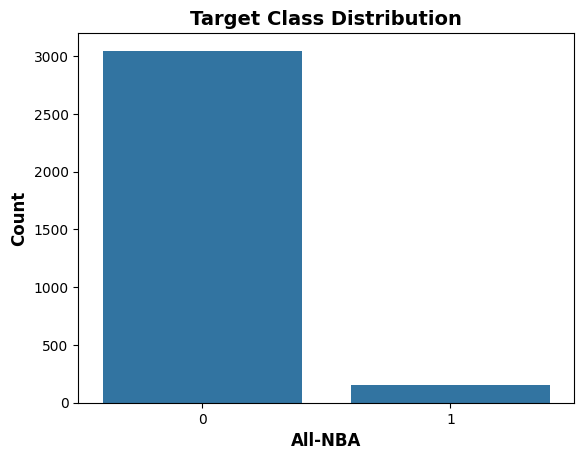

In [6]:
# Checking the distribution of the target variable
print(f'{df['all_nba'].value_counts(normalize = True).round(3)}\n')

sns.countplot(x = 'all_nba', data = df)
plt.title('Target Class Distribution', fontsize = 14, weight = 'bold')
plt.xlabel('All-NBA', fontsize = 12, weight = 'bold')
plt.ylabel('Count', fontsize = 12, weight = 'bold')
plt.show()

# The target variable is extremely imbalanced

In [7]:
# Defining the predictor and the response variables
X = df.drop(columns = ['player_id', 'player', 'season', 'all_nba'])
y = df['all_nba']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify = y, random_state = 23
)

In [8]:
# Defining a parameter distribution with 5 separate classification models and ranges for hyperparameters to 
#    prepare for Randomized Search CV
# No class weights specified for Logstic Regression or SVC
params_smote = [
    {
        'clf': [LGR()],
        'clf__C': loguniform(1e-3, 1e2)
    },
    {
        'clf': [RFC(random_state = 23)],
        'clf__max_depth': [None] + list(np.arange(3, 31, 3)),
        'clf__n_estimators': np.arange(100, 1001, 100),
        'clf__min_samples_split': randint(2, 15),
        'clf__min_samples_leaf': randint(1, 10),
        'clf__max_features': ['sqrt', 'log2', 0.5, 0.75]
    },
    {
        'clf': [KNN()],
        'clf__n_neighbors': np.arange(2, 31, 2),
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2]
    },
    {
        'clf': [SVC(probability = True)],
        'clf__C': loguniform(1e-3, 1e2),
        'clf__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'clf': [XGBC(random_state = 23)],
        'clf__max_depth': np.arange(2, 15),
        'clf__n_estimators': np.arange(100, 1001, 100),
        'clf__learning_rate': loguniform(0.01, 0.3),
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 1, 5]
    }
]

# Making an imbalanced pipeline with SMOTE
pipe_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state = 23)),
    ('clf', LGR())
])

# running the search
search_smote, best_model_smote = run_search(
    X_train, y_train, pipe_smote, params_smote, name = 'with_SMOTE'
)

# The model with the highest average precision is Logistic Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[with_SMOTE] Best Parameters: {'clf': LogisticRegression(), 'clf__C': 0.6190644715371475}
[with_SMOTE] Best CV average precision: 0.899



In [9]:
# Defining a parameter distribution with 5 separate classification models and ranges for hyperparameters to 
#    prepare for Randomized Search CV
# Class weights specified for Logistic Regression and SVC to make up for no SMOTE use in the pipeline
params_weighted = [
    {
        'clf': [LGR(class_weight = 'balanced')],
        'clf__C': loguniform(1e-3, 1e2)
    },
    {
        'clf': [RFC(random_state = 23)],
        'clf__max_depth': [None] + list(np.arange(3, 31, 3)),
        'clf__n_estimators': np.arange(100, 1001, 100),
        'clf__min_samples_split': randint(2, 15),
        'clf__min_samples_leaf': randint(1, 10),
        'clf__max_features': ['sqrt', 'log2', 0.5, 0.75]
    },
    {
        'clf': [KNN()],
        'clf__n_neighbors': np.arange(2, 31, 2),
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2]
    },
    {
        'clf': [SVC(class_weight = 'balanced', probability = True)],
        'clf__C': loguniform(1e-3, 1e2),
        'clf__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'clf': [XGBC(random_state = 23)],
        'clf__max_depth': np.arange(2, 15),
        'clf__n_estimators': np.arange(100, 1001, 100),
        'clf__learning_rate': loguniform(0.01, 0.3),
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 1, 5]
    }
]

# Making a pipeline without SMOTE
pipe_weighted = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGR())
])

# running the search
search_weighted, best_model_weighted = run_search(
    X_train, y_train, pipe_weighted, params_weighted, name = 'class_weighted'
)

# The model with the highest average precision is Logistic Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[class_weighted] Best Parameters: {'clf': LogisticRegression(class_weight='balanced'), 'clf__C': 1.029056493183958}
[class_weighted] Best CV average precision: 0.900



In [10]:
# Generating the threshold summaries for both pipelines
summary_smote = get_threshold_summary(best_model_smote, X_train, y_train)
summary_weighted = get_threshold_summary(best_model_weighted, X_train, y_train)

In [11]:
# Printing the organized summaries for both pipelines
print_threshold_summary('with_SMOTE', summary_smote)
print_threshold_summary('class_weighted', summary_weighted)


=== Threshold summary for with_SMOTE ===
Mean threshold: 0.909
Median threshold: 0.928
Std: 0.078, IQR: 0.087
Chosen threshold: 0.909 (stable thresholds → mean)
Mean F1 across folds (best per-fold): 0.833

=== Threshold summary for class_weighted ===
Mean threshold: 0.921
Median threshold: 0.912
Std: 0.059, IQR: 0.091
Chosen threshold: 0.921 (stable thresholds → mean)
Mean F1 across folds (best per-fold): 0.830


# Chosen Model → Class-Weighted (Threshold: 0.921)
- Cross-validated average precision scores at the default threshold of 0.5 were nearly identical for both models (with SMOTE: 0.899, class-weighted: 0.900).
- The optimized thresholds for each model yielded similar mean F1 scores across folds (with SMOTE: 0.833, class-weighted: 0.830).
- Given that the class-weighted model achieves comparable performance while being less computationally intensive, it was selected as the final model.

In [13]:
# Displaying the final pipeline for the model
best_model_weighted

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=1.029056493183958,
                                    class_weight='balanced'))])

In [14]:
# Saving the final model 
joblib.dump({'model': best_model_weighted, 'threshold': .921}, '../models/best_model.pkl')

['../models/best_model.pkl']

In [16]:
# Saving the test sets
joblib.dump(X_test, '../data/processed/X_test.pkl')
joblib.dump(y_test, '../data/processed/y_test.pkl')

['../data/processed/y_test.pkl']